# <center> **ДИПЛОМНАЯ РАБОТА**
# <center> **на тему:** 
# <center> <U>**Бриф «Лаборатории исследований гражданского общества».**
# <center> **Государственные деньги у НКО**</U>

# *Описание проекта*
В распоряжении есть дамп данных обо всех НКО России,  
в котором содержится информация о получении государственных грантов,  
госконтрактов и субсидий, регионе и дате регистрации,  
а также ОКВЭД (классификатор экономической деятельности).
# *Постановка задачи*
Проверить, есть ли зависимость вероятности получения грантов от государства/госконтрактов:  
➔ от региона регистрации организации;  
➔ от возраста организации;  
➔ от экономической деятельности организации.  
По желанию можно провести любые дополнительные проверки.
# *Исходные данные*
Источник данных — проект «Открытые НКО» <https://openngo.ru/>  
Дамп данных в формате JSON (актуален на 16.08.2023) <https://openngo.ru/opendata/>  
Описание полей на GitHub <https://github.com/infoculture/openngo-data-reference/wiki/Характеристики-и-расшифровки-открытых-данных>

## Библиотеки

In [1]:
# общие библиотеки
import pandas as pd # для работы с данными
import numpy as np  # для выполнения научных вычислений
import ast # для безопасного преобразования строки в список с помощью функции literal_eval()
import json # для работы с данными в формате JSON
from datetime import datetime # для работы датой и временем
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для формирования моделей
from sklearn.model_selection import train_test_split # для разделения датасета
from sklearn import linear_model # линейные модели
from sklearn import ensemble # ансамбли
from sklearn.model_selection import GridSearchCV # для поиска наилучших гиперпараметров

# метрики
from sklearn import metrics #метрики
from sklearn.metrics import precision_score

In [33]:
df_full = pd.read_csv("data/target_data.csv")
df_full.head(2)

C:\Users\glaz\AppData\Local\Temp\ipykernel_17476\207094577.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv("data/target_data.csv")


,addOkved,address,chiefs,dateLiquid,dateOgrn,dateReg,email,fullName,inn,kpp,...,okogu,oktmo,socialMedia,opfType,reports,incomeTotal,incomeDetail,incomeRank,totalSumGrants,totalSumContract
0,"[{'code': '72.4', 'name': 'Деятельность по соз...","422430, РЕСПУБЛИКА ТАТАРСТАН, ГОРОД БУИНСК, УЛ...","[{'name': 'ХАЛИКОВ РАШИТ РИНАТОВИЧ', 'title': ...",{'$date': '2012-12-17T00:00:00.000Z'},{'$date': '2010-03-03T00:00:00.000Z'},NaN,NaN,"НЕКОММЕРЧЕСКОЕ ПАРТНЕРСТВО ""ИНФОРМАЦИОННО-КОНС...",1.614010e+09,161401001.0,...,"{'code': None, 'name': None}","{'code': None, 'name': None}","{'facebook': None, 'instagram': None, 'ok': No...",Некоммерческие партнерства,[],0,"{'grants': {'totalCount': 0, 'totalSum': 0}, '...",Наличие доходов из доступных источников не уст...,0,0
1,"[{'code': '67.20.2', 'name': 'Деятельность спе...","430030, РЕСПУБЛИКА МОРДОВИЯ, ГОРОД САРАНСК, УЛ...","[{'name': 'ПУЗАНОВ ВЛАДИМИР ВЛАДИМИРОВИЧ', 'ti...",{'$date': '2014-11-10T00:00:00.000Z'},{'$date': '2010-05-11T00:00:00.000Z'},NaN,NaN,"НЕКОММЕРЧЕСКОЕ ПАРТНЕРСТВО ""МЕЖРЕГИОНАЛЬНЫЙ НА...",1.327011e+09,132701001.0,...,"{'code': None, 'name': None}","{'code': None, 'name': None}","{'facebook': None, 'instagram': None, 'ok': No...",Некоммерческие партнерства,"[{'type': 'Заявление', 'reportId': '19445801',...",0,"{'grants': {'totalCount': 0, 'totalSum': 0}, '...",Наличие доходов из доступных источников не уст...,0,0


In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752072 entries, 0 to 752071
Data columns (total 42 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   addOkved            752072 non-null  object 
 1   address             752072 non-null  object 
 2   chiefs              752072 non-null  object 
 3   dateLiquid          406460 non-null  object 
 4   dateOgrn            752072 non-null  object 
 5   dateReg             321581 non-null  object 
 6   email               11086 non-null   object 
 7   fullName            752072 non-null  object 
 8   inn                 749468 non-null  float64
 9   kpp                 748411 non-null  float64
 10  mainOkved           752072 non-null  object 
 11  ogrn                752072 non-null  int64  
 12  opf                 752072 non-null  object 
 13  predecessors        752072 non-null  object 
 14  shortName           602778 non-null  object 
 15  statusInfo          752072 non-nul

In [4]:
missing_columns = df_full.columns[df_full.isnull().any()]
for column in missing_columns:
    missing_count = df_full[column].isnull().sum()
    print(f"'{column}': {missing_count}")

'dateLiquid': 345612
'dateReg': 430491
'email': 740986
'inn': 2604
'kpp': 3661
'shortName': 149294
'foundersConfig': 480724
'regionName': 25
'minjustForm': 286997
'minjustStatus': 285495
'minjustRegNum': 285749
'okpo': 406694
'hasRegionalSupport': 752072
'website': 746785
'website_punycode': 746785


In [5]:
df_full[df_full['regionCode'] == 0][['regionCode','address']]

,regionCode,address
101323,0,"420108, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА АМИРХАНА, ..."
102989,0,"РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА М.ДЖАЛИЛЯ, ДОМ 3"
191591,0,"420111, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА М.ДЖАЛИЛЯ,..."
217069,0,"420138, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ПРОСПЕКТ П..."
217070,0,"420140, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА Ю.ФУЧИКА, ..."
218430,0,"420138, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ПРОСПЕКТ П..."
218468,0,"420103, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА АМИРХАНА, ..."
218475,0,"420104, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА Р.ЗОРГЕ, Д..."
218514,0,"420087, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА Р.ЗОРГЕ, Д..."
220009,0,"420101, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА МАВЛЮТОВА,..."


In [34]:
#Колиство строк, в котором код - нулевой, - 25. Во всех строках представлен регион - "РЕСПУБЛИКА ТАТАРСТАН".
#Заменим нулевой код региона на значение 16 - "РЕСПУБЛИКА ТАТАРСТАН".

df_full['regionCode'] = df_full['regionCode'].apply(lambda x: 16 if x == 0 else x)
df_full[df_full['regionCode'] == 0][['regionCode','address']]

,regionCode,address


In [35]:
million_cities = ['Москва','Санкт-Петербург','Новосибирск', 'Екатеринбург', 'Нижний Новгород', 'Казань', 'Челябинск', 'Омск', 
                  'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь', 'Воронеж', 'Волгоград', 'Краснодар']
#Регионы городов миллионников
region_million_cities = [2,16,23,24,34,36,52,54,55,59,61,63,66,74,77,78]
#Регионы центрального федерального округа
region_cfo = [31,32,33,37,40,44,46,48,50,57,62,67,68,69,71,76]
#Регионы Северо-Западного федерального округа
region_szfo = [10,11,29,35,39,47,51,53,60,83]
#Регионы южного федерального округа
region_ufo = [1,8,30,91,92]
#Регионы Северо-Кавказского федерального округа
region_skfo = [5,6,7,9,15,20,26]
#Регионы Приволжского федерального округа
region_pfo = [12,13,18,21,43,56,58,64,73,81]
#Регионы Уральского федерального округа
region_urfo = [45,72,86,89]
#Регионы Сибирского федерального округа
region_sfo = [4,17,19,22,38,42,70,75,80,84,85,88]
#Регионы Дальневосточного федерального округа
region_dfo = [3,14,25,27,28,41,49,65,75,79,82,87]
#Города республиканского значения
region_resp = [99]

def region_def(region_cod):
    if region_cod in region_million_cities:
        return region_cod
    elif region_cod in region_cfo:
        return 101
    elif region_cod in region_szfo:
        return 102
    elif region_cod in region_ufo:
        return 103
    elif region_cod in region_skfo:
        return 104
    elif region_cod in region_pfo:
        return 105
    elif region_cod in region_urfo:
        return 106
    elif region_cod in region_sfo:
        return 107
    elif region_cod in region_dfo:
        return 108
    elif region_cod in region_resp:
        return 109
    else:
        return 1000

df_full['regionCode'] = df_full['regionCode'].apply(lambda x: region_def(x))
    

In [36]:
df_grouped = df_full.groupby('regionCode')['incomeTotal'].apply(lambda x: (x == 1).mean() * 100).reset_index(name='percentage')
df_sorted = df_grouped.sort_values(by='percentage', ascending=False)
#df_sorted.head(7)
df_sorted

,regionCode,percentage
15,78,7.281538
14,77,6.967624
9,59,6.693698
4,34,6.136325
21,106,5.873494
13,74,4.949020
1,16,4.898101
11,63,4.860221
22,107,4.831875
5,36,4.780919


Обработка кодов:
1. mainOkved: сведения об основном ОКВЭД - выводим только код

In [37]:
#Обработка кодов

#Функция для извлечения значений 'code' из словаря признака
def code_dict(df_dict,del_symbol,type_ret):
    #аргумент df_dict: значение признака, представляет собой словарь; 
    #                             у каждого словаря есть ключи: code, name.
    #аргумент del_symbol: количество первых символов, которые нужно удалить
    #аргумент type_ret: тип данных функции на выходе
    #return: код признака    
    df_dict = df_dict.replace("'", '') #Удаление апострофов из значений в столбце
    df_dict = df_dict[del_symbol:] #Удаление первых символов
    df_dict = df_dict.split(',')[0] #Удаление всех символов после запятой включительно
    if type_ret == 'int':
        if df_dict == 'None':
            return int(0)
        else:
            return int(df_dict)
    else:
        return df_dict

#Обработка mainOkved (сведения об основном ОКВЭД): выводим только код
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: code_dict(x,7,'str'))

df_full[['mainOkved']]


,mainOkved
0,74.1
1,75.25.1
2,None
3,None
4,None
...,...
752067,64.99
752068,69
752069,None
752070,94.99


In [38]:
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: '0' if x == 'None' else x)
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: x.split('.')[0])
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: int(x))

In [39]:
df_mainOkved_none = pd.read_csv("data/full_init_data.csv")
df_mainOkved_none = df_mainOkved_none[['ogrn','predict_mainOkved']]
df_mainOkved_none.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203032 entries, 0 to 203031
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   ogrn               203032 non-null  int64
 1   predict_mainOkved  203032 non-null  int64
dtypes: int64(2)
memory usage: 3.1 MB


C:\Users\glaz\AppData\Local\Temp\ipykernel_17476\2614982333.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mainOkved_none = pd.read_csv("data/full_init_data.csv")


In [40]:
def mainOkved_none_def(ogrn_arg):
    mainOkved_new = df_mainOkved_none[df_mainOkved_none['ogrn'] == ogrn_arg]['predict_mainOkved'].values[0]
    return mainOkved_new


df_full['mainOkved'] = df_full.apply(lambda x: x['mainOkved'] if x['mainOkved'] > 0 else mainOkved_none_def(x['ogrn']), axis=1)

df_full['mainOkved']

0         74
1         75
2         74
3         91
4         70
          ..
752067    64
752068    69
752069    91
752070    94
752071    82
Name: mainOkved, Length: 752072, dtype: int64

In [41]:
#Обработка mainOkved

#Словарь ОКВЭД
mainOkved_dict = dict()
mainOkved_dict = {101: ['01','02','03'], 
                  102: ['05','06','07','08','09'], 
                  103: ['10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33'],
                  104: ['35'],                  
                  105: ['36','37','38','39'],
                  106: ['41','42','43'],
                  107: ['45','46','47'],
                  108: ['49','50','51','52','53'],
                  109: ['55','56'],
                  110: ['58','59','60','61','62','63'],
                  111: ['64','65','66'],
                  112: ['68'],
                  113: ['69','70','71','72','73','74','75'],
                  114: ['77','78','79','80','81','82'],
                  115: ['84'],
                  116: ['85'],
                  117: ['86','87','88'],
                  118: ['90','91','92','93'],
                  119: ['94','95','96'],
                  120: ['97','98'],
                  121: ['99']}

def mainOkved_def(mainOkved_cod):
    for key, values in mainOkved_dict.items():
        if mainOkved_cod in values:
            return key
    key_none = '10' + mainOkved_cod
    return key_none

#Оставляем только первый символ до точки
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: str(x))
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: mainOkved_def(x))
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: int(x))

df_full['mainOkved'].head(3)

0    113
1    113
2    113
Name: mainOkved, dtype: int64

In [42]:
#df_grouped = df_full[df_full['incomeTotal'] == 1].groupby('mainOkved').size().reset_index(name='count')
df_grouped = df_full.groupby('mainOkved')['incomeTotal'].apply(lambda x: (x == 1).mean() * 100).reset_index(name='percentage')
df_sorted = df_grouped.sort_values(by='percentage', ascending=False)
df_sorted.head(7)


,mainOkved,percentage
8,109,25.729927
15,116,18.127544
16,117,13.424995
4,105,11.867583
6,107,10.099464
14,115,7.981377
9,110,7.184226


Обработка дат
1. originDate: дата регистрации организаций
2. dateLiquid: дата ликвидации юрлица

Целевой признак с 1 начинается с 1964 года.

In [43]:
#Обработка дат

#Для действующих организаций значение признака dateLiquid поставим в '0'
df_full['dateLiquid'] = df_full['dateLiquid'].fillna('0')

#Функция для извлечения года из признака
def date_dict(df_date):
    #аргумент: значение признака, которое представляет собой дату следующего вида - {'$date': '2012-12-17T00:00:00.000Z'}
    #return: год (тип float)    
    if df_date != '0':
        df_date = df_date.replace("'", '') #Удаление апострофов из значений в столбце
        df_date = df_date[7:] #Удаление первых символов
        df_date = df_date.split('-')[0] #Удаление всех символов после запятой включительно
        return int(df_date)
    else:
        return int(df_date)

df_full['originDate'] = df_full['originDate'].apply(lambda x: date_dict(x))
df_full['dateLiquid'] = df_full['dateLiquid'].apply(lambda x: date_dict(x))

# Функция для расчета нового значения по алгоритму
def calculate_new_value(row):
    if row['dateLiquid'] != 0:
        return row['dateLiquid'] - row['originDate']
    else:
        current_date = datetime.now().year
        return int(str(current_date)) - row['originDate']

# Применяем функцию к каждой строке DataFrame и создаем новый столбец
df_full['diffYear'] = df_full.apply(lambda row: calculate_new_value(row), axis=1)

df_full[['originDate','dateLiquid','diffYear']].describe()

,originDate,dateLiquid,diffYear
count,752072.000000,752072.000000,752072.000000
mean,2004.349588,1087.709941,13.022774
std,9.207059,1003.001238,9.176799
min,1881.000000,0.000000,-2.000000
25%,1999.000000,0.000000,6.000000
50%,2004.000000,2006.000000,11.000000
75%,2011.000000,2013.000000,18.000000
max,2021.000000,2021.000000,138.000000


In [44]:
df_full = df_full[(df_full['diffYear'] >= 0)]
df_full[['originDate','dateLiquid','diffYear']].describe()

,originDate,dateLiquid,diffYear
count,752068.000000,752068.000000,752068.000000
mean,2004.349571,1087.705059,13.022853
std,9.207080,1003.001671,9.176760
min,1881.000000,0.000000,0.000000
25%,1999.000000,0.000000,6.000000
50%,2004.000000,2006.000000,11.000000
75%,2011.000000,2013.000000,18.000000
max,2021.000000,2021.000000,138.000000


<Figure size 1500x600 with 0 Axes>

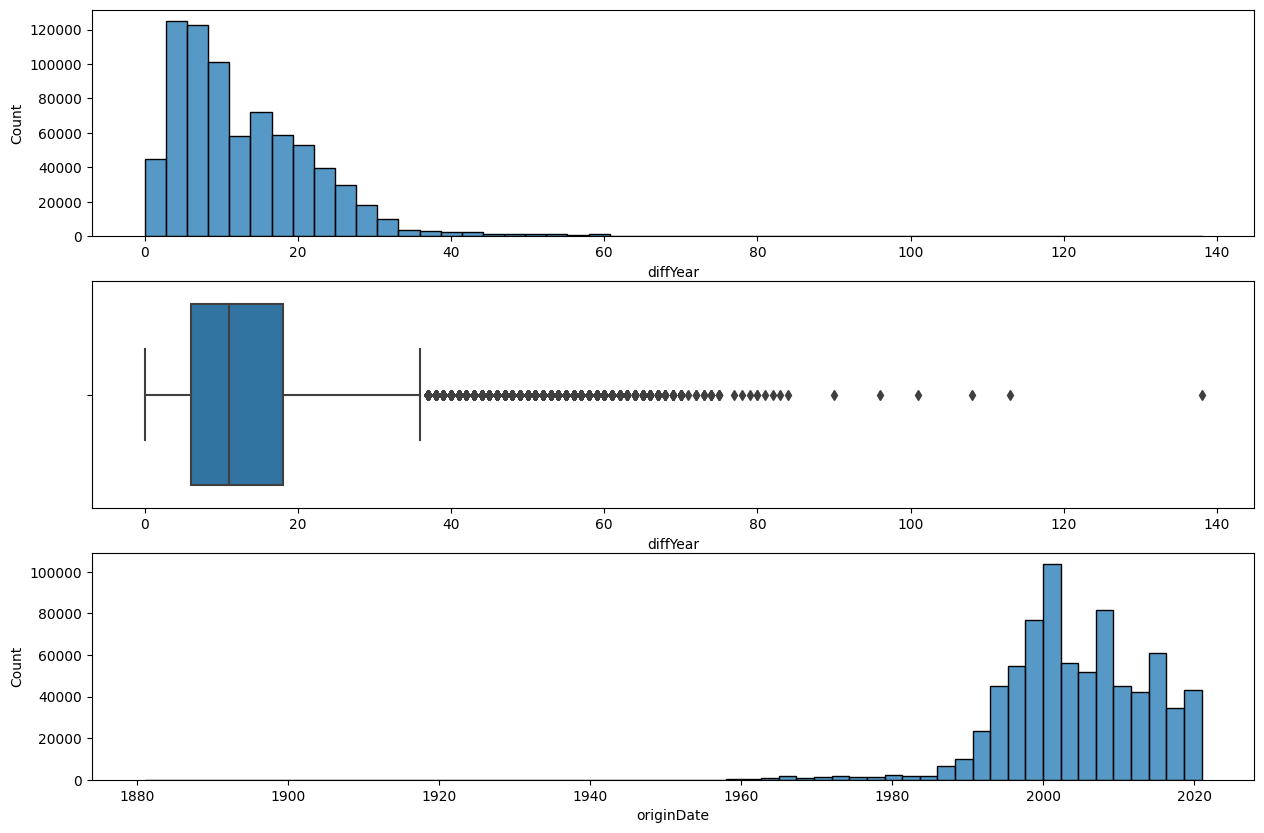

In [45]:
# Установить размер графика
plt.figure(figsize=(15, 6))
#plt.hist(df_full['diffYear'], bins=100)
#plt.boxplot(df_full['diffYear'],vert=False);

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
sns.histplot(
    data=df_full,
    x='diffYear',
    bins=50,   
    ax=axes[0]
);
sns.boxplot(
    data=df_full,
    x='diffYear',
    ax=axes[1]
);
sns.histplot(
    data=df_full,
    x='originDate',
    bins=60,   
    ax=axes[2]
);

In [46]:
df_full = df_full[df_full['originDate'] > 1987]

<Figure size 1500x600 with 0 Axes>

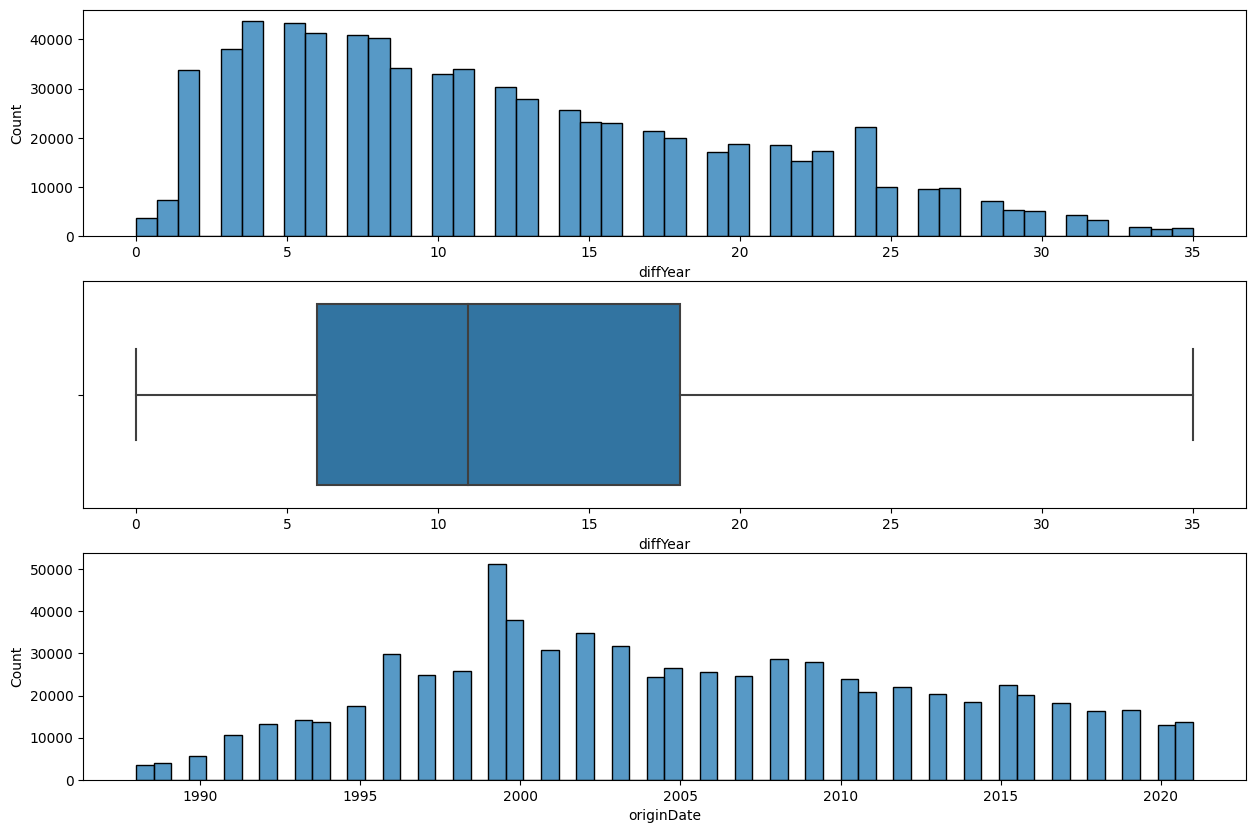

In [19]:
# Установить размер графика
plt.figure(figsize=(15, 6))
#plt.hist(df_full['diffYear'], bins=100)
#plt.boxplot(df_full['diffYear'],vert=False);

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
sns.histplot(
    data=df_full,
    x='diffYear',
    bins=50,   
    ax=axes[0]
);
sns.boxplot(
    data=df_full,
    x='diffYear',
    ax=axes[1]
);
sns.histplot(
    data=df_full,
    x='originDate',
    bins=60,   
    ax=axes[2]
);

Перевод значений признаков в бинарный тип:
1. website: наличие сайта; 1 - имеется, 0 - нет 
2. predecessors: предшественники; 1 - имеется, 0 - нет
3. successors: предшественники; 1 - имеется, 0 - нет
4. addOkved: дополнительный ОКВЭД - наличие дополнительных ОКВЭД: 1 - есть, 0 - нет

In [47]:
#Перевод значений признаков в бинарный тип

#predecessors: предшественники; 1 - имеется, 0 - нет
df_full['predecessors'] = df_full['predecessors'].apply(lambda x: 0 if x == '[]' else 1)

# Функция для извлечения значений 'code' из списка словарей признака
def code_list(df_list):
    #аргумент: значение признака, представляет собой список, 
    #                             элементы которого словари; 
    #                             у каждого словаря есть ключи: code, name, version.
    #return: 1 - список не пустой, 0 - список пустой
    addOkved_list = ast.literal_eval(df_list)
    if len(addOkved_list) > 0:
        return 1
    else:
        return 0

#Обработка addOkved (дополнительный ОКВЭД): наличие дополнительных ОКВЭД: 1 - есть, 0 - нет
df_full['addOkved'] = df_full['addOkved'].apply(code_list)


df_full[['predecessors','addOkved']]

,predecessors,successors,addOkved
0,0,0,1
1,0,0,1
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
752067,0,0,1
752068,0,0,1
752069,0,0,0
752070,0,0,1


In [48]:
df_full['opfType'].unique()

def opfType_def(arg):
       opfType_dict = {'Некоммерческие партнерства': 1, 'Ассоциации и бюро': 2,
              'Общественные организации': 3, 'Кооперативы и товарищества': 4,
              'Учреждения': 5, 'Фонды': 6, 'Автономные некоммерческие организации': 7,
              'Профессиональные союзы': 8, 'Некоммерческие организации': 9, 'Другое': 10,
              'Общины малочисленных народов': 11, 'Религиозные организации': 12,
              'Политические партии': 13, 'Казачьи общества': 14}
       return opfType_dict[arg]

df_full['opfType'] = df_full['opfType'].apply(lambda x: opfType_def(x))
df_full['opfType']

0         1
1         1
2         2
3         3
4         4
         ..
752067    6
752068    1
752069    3
752070    6
752071    7
Name: opfType, Length: 733471, dtype: int64

In [49]:
df_full = df_full.drop(['totalSumGrants', 'totalSumContract'], axis=1)

Перечень столбцов/признаков, значение которых объективно не могут влияют на поставленную задачу, на целевой признак:
1. chiefs: руководители организации (не будем рассматривать вариант влияния субъекта на целевой признак, иными словами коррупцию) 
2. address: юридический адрес (регион можно определить с отдельного признака)
3. email: email организации
4. fullName: полное наименование организации
5. shortName: сокращенное наименование организации
6. inn
7. kpp
8. regionName: название региона организации
9. statusDetail
10. minjustStatus: статус НКО в системе Минюста РФ - УНРО (много пропусков, есть аналог egrulStatus)
11. minjustRegNum: реестровый номер НКО в системе Минюста РФ - УНРО
12. hasRegionalSupport: региональная поддержка в качестве СО НКО (все ячейки не заполнены)
13. okato: сведения об ОКАТО
14. oktmo: сведения об ОКТМО
15. okpo: ОКПО
16. dateReg: дата регистрации организаций (имеет более полный аналог признака - originDate)
17. dateOgrn: дата присвоения ОГРН (имеет более полный аналог признака - originDate)
18. incomeDetail: детализация сведений о доходах (имеет более полный аналог в признаках incomeTotal, totalSumGrants, totalSumContract)
19. incomeRank: уровень дохода (имеет более полный аналог в признаках incomeTotal, totalSumGrants, totalSumContract)
20. website_punycode: домен вебсайта организации (мало заполненных строк)
21. website: домен вебсайта организации (мало заполненных строк)
22. reports: отчеты организации, поданные в Минюст РФ (утечка целевой переменной)
23. socialMedia: сведения об учетных записях организации в соцсетях (количество заполненных строк - 6)
24. egrulStatus: статус организации на основании данных ЕГРЮЛ (доходы возникают, когда организация действует)
25. opf: сведения об организационно-правовой форме (имеет более полный аналог в признаке opfType)
26. foundersConfig: состав учредителей (признак скорее всего нужный, но мало заполненных строк; в рамках диплома исключаем)
27. minjustForm: форма НКО, согласно системе Минюста РФ (имеет более полный аналог в признаке opfType)
28. okogu: сведения об ОКОГУ: (признак скорее всего нужный, но мало заполненных строк; в рамках диплома исключаем)
29. okfs: сведения об ОКФС: (признак скорее всего нужный, но мало заполненных строк; в рамках диплома исключаем)
30. statusInfo: информация об ошибке регистрации (утечка целевой переменной)
40. ogrn: ОГРН
41. originDate
42. dateLiquid
43. successors

In [50]:
#Удаление столбцов/признаков, значение которых объективно не могут влияют на поставленную задачу, на целевой признак
df_full = df_full.drop(['chiefs', 'address', 'email', 'fullName', 'shortName', 'inn', 'kpp', 'regionName', 'foundersConfig', 'minjustForm', 'website',
                        'statusDetail','minjustStatus','minjustRegNum','hasRegionalSupport','okato','oktmo', 'egrulStatus', 'opf', 'okogu', 'okfs', 'successors',
                        'okpo','dateReg','dateOgrn','incomeDetail','incomeRank', 'website_punycode', 'reports','socialMedia','statusInfo', 'ogrn', 'originDate','dateLiquid'], axis=1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   addOkved      733471 non-null  int64
 1   mainOkved     733471 non-null  int64
 2   predecessors  733471 non-null  int64
 3   regionCode    733471 non-null  int64
 4   opfType       733471 non-null  int64
 5   incomeTotal   733471 non-null  int64
 6   diffYear      733471 non-null  int64
dtypes: int64(7)
memory usage: 44.8 MB


<AxesSubplot: >

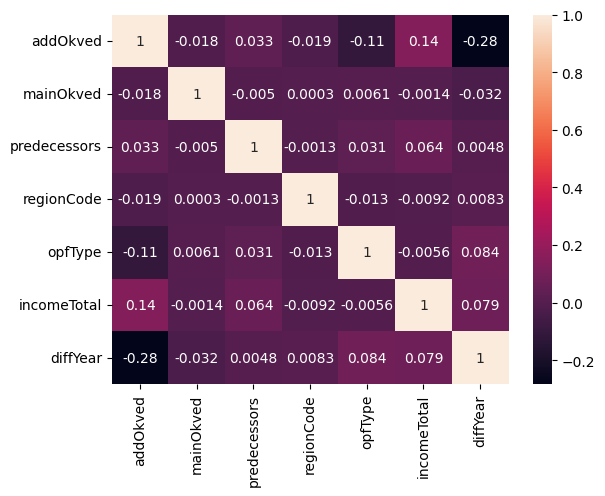

In [51]:
sns.heatmap(df_full.corr(), annot=True)

In [25]:
df_full['mainOkved'].unique()

array([ 113,  118,  108,  116,  101,  114,  119,  111,  112,  117,  105,
        106,  103,  107,  110,  115,  104, 1067, 1040,  109,  102,  121,
        120], dtype=int64)

In [52]:
#Закодируем mainOkved
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

encoder = ce.OneHotEncoder(cols=['mainOkved'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df_full['mainOkved'])
df_full = pd.concat([df_full, type_bin], axis=1)

df_full.iloc[:5,9:15]

,mainOkved_108.0,mainOkved_116.0,mainOkved_101.0,mainOkved_114.0,mainOkved_119.0,mainOkved_111.0
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [20]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   mainOkved         733471 non-null  int64
 2   predecessors      733471 non-null  int64
 3   regionCode        733471 non-null  int64
 4   opfType           733471 non-null  int64
 5   incomeTotal       733471 non-null  int64
 6   diffYear          733471 non-null  int64
 7   mainOkved_113.0   733471 non-null  int64
 8   mainOkved_118.0   733471 non-null  int64
 9   mainOkved_108.0   733471 non-null  int64
 10  mainOkved_116.0   733471 non-null  int64
 11  mainOkved_101.0   733471 non-null  int64
 12  mainOkved_114.0   733471 non-null  int64
 13  mainOkved_119.0   733471 non-null  int64
 14  mainOkved_111.0   733471 non-null  int64
 15  mainOkved_112.0   733471 non-null  int64
 16  mainOkved_117.0   733471 non-null  int64
 17  mainOkved_

In [53]:
#Закодируем regionCode
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

encoder = ce.OneHotEncoder(cols=['regionCode'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df_full['regionCode'])
df_full = pd.concat([df_full, type_bin], axis=1)

df_full.iloc[:5,32:40]

,regionCode_77.0,regionCode_102.0,regionCode_107.0,regionCode_23.0,regionCode_101.0,regionCode_66.0,regionCode_104.0,regionCode_63.0
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0


In [29]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 56 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   mainOkved         733471 non-null  int64
 2   predecessors      733471 non-null  int64
 3   successors        733471 non-null  int64
 4   regionCode        733471 non-null  int64
 5   opfType           733471 non-null  int64
 6   incomeTotal       733471 non-null  int64
 7   diffYear          733471 non-null  int64
 8   mainOkved_113.0   733471 non-null  int64
 9   mainOkved_118.0   733471 non-null  int64
 10  mainOkved_108.0   733471 non-null  int64
 11  mainOkved_116.0   733471 non-null  int64
 12  mainOkved_101.0   733471 non-null  int64
 13  mainOkved_114.0   733471 non-null  int64
 14  mainOkved_119.0   733471 non-null  int64
 15  mainOkved_111.0   733471 non-null  int64
 16  mainOkved_112.0   733471 non-null  int64
 17  mainOkved_

In [54]:
#Закодируем opfType
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

encoder = ce.OneHotEncoder(cols=['opfType'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df_full['opfType'])
df_full = pd.concat([df_full, type_bin], axis=1)

df_full.iloc[:5,57:71]

,opfType_3.0,opfType_4.0,opfType_5.0,opfType_6.0,opfType_7.0,opfType_8.0,opfType_9.0,opfType_10.0,opfType_11.0,opfType_12.0,opfType_13.0,opfType_14.0
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0


In [55]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 69 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   mainOkved         733471 non-null  int64
 2   predecessors      733471 non-null  int64
 3   regionCode        733471 non-null  int64
 4   opfType           733471 non-null  int64
 5   incomeTotal       733471 non-null  int64
 6   diffYear          733471 non-null  int64
 7   mainOkved_113.0   733471 non-null  int64
 8   mainOkved_118.0   733471 non-null  int64
 9   mainOkved_108.0   733471 non-null  int64
 10  mainOkved_116.0   733471 non-null  int64
 11  mainOkved_101.0   733471 non-null  int64
 12  mainOkved_114.0   733471 non-null  int64
 13  mainOkved_119.0   733471 non-null  int64
 14  mainOkved_111.0   733471 non-null  int64
 15  mainOkved_112.0   733471 non-null  int64
 16  mainOkved_117.0   733471 non-null  int64
 17  mainOkved_

In [32]:
#Закодируем diffYear
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

#encoder = ce.OneHotEncoder(cols=['diffYear'], use_cat_names=True) # указываем столбец для кодирования
#type_bin = encoder.fit_transform(df_full['diffYear'])
#df_full = pd.concat([df_full, type_bin], axis=1)

#df_full.iloc[:5,70:80]

,diffYear_2.0,diffYear_4.0,diffYear_17.0,diffYear_12.0,diffYear_18.0,diffYear_15.0,diffYear_14.0,diffYear_10.0,diffYear_3.0,diffYear_21.0
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [31]:
#df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 67 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   predecessors      733471 non-null  int64
 2   incomeTotal       733471 non-null  int64
 3   diffYear          733471 non-null  int64
 4   mainOkved_113.0   733471 non-null  int64
 5   mainOkved_118.0   733471 non-null  int64
 6   mainOkved_108.0   733471 non-null  int64
 7   mainOkved_116.0   733471 non-null  int64
 8   mainOkved_101.0   733471 non-null  int64
 9   mainOkved_114.0   733471 non-null  int64
 10  mainOkved_119.0   733471 non-null  int64
 11  mainOkved_111.0   733471 non-null  int64
 12  mainOkved_112.0   733471 non-null  int64
 13  mainOkved_117.0   733471 non-null  int64
 14  mainOkved_105.0   733471 non-null  int64
 15  mainOkved_106.0   733471 non-null  int64
 16  mainOkved_103.0   733471 non-null  int64
 17  mainOkved_

In [56]:
#Удаление столбцов/признаков, значение которых объективно не могут влияют на поставленную задачу, на целевой признак
df_full = df_full.drop(['mainOkved','regionCode','opfType'], axis=1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 66 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   predecessors      733471 non-null  int64
 2   incomeTotal       733471 non-null  int64
 3   diffYear          733471 non-null  int64
 4   mainOkved_113.0   733471 non-null  int64
 5   mainOkved_118.0   733471 non-null  int64
 6   mainOkved_108.0   733471 non-null  int64
 7   mainOkved_116.0   733471 non-null  int64
 8   mainOkved_101.0   733471 non-null  int64
 9   mainOkved_114.0   733471 non-null  int64
 10  mainOkved_119.0   733471 non-null  int64
 11  mainOkved_111.0   733471 non-null  int64
 12  mainOkved_112.0   733471 non-null  int64
 13  mainOkved_117.0   733471 non-null  int64
 14  mainOkved_105.0   733471 non-null  int64
 15  mainOkved_106.0   733471 non-null  int64
 16  mainOkved_103.0   733471 non-null  int64
 17  mainOkved_

In [57]:
# зафксируем random_state
random_state = 42

In [58]:
# Разделение на признаки и целевую переменную
X = df_full.drop('incomeTotal', axis=1)  # Признаки (все столбцы, кроме целевой переменной)
y = df_full['incomeTotal']               # Целевая переменная

#Стратифицированное разделение на train и test выборки
#Размер тестовой выборки составляет 20% от всего набора данных
#Передаем параметр stratify=y,
#   который указывает на использование стратификации на основе целевой переменной y,
#   чтобы сохранить баланс классов в обоих выборках.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

# Вывод размерностей полученных выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (586776, 65)
Размер тестовой выборки: (146695, 65)


Precision (точность), или PPV (Positive Predictive Value) — это доля объектов, которые действительно являются положительными, по отношению ко всем объектам, названным моделью положительными.
Интерпретация: способность отделить класс 1 от класса 0. Чем больше precision, тем меньше ложных попаданий. То есть чем ближе precision к 1, тем меньше вероятность модели допустить ошибку I рода.
Используется в задачах, где важно минимальное количество ложноположительных срабатываний модели.
Можно использовать на несбалансированных выборках.

Recall (полнота), или TPR (True Positive Rate) — это доля объектов, названных классификатором положительными, по отношению ко всем объектам положительного класса.
Интерпретация: способность модели обнаруживать класс 1 вообще, то есть охват класса 1. Заметьте, что метрика зависит от количества ложноотрицательных срабатываний. То есть чем ближе recall к 1, тем меньше вероятность модели допустить ошибку II рода.
Можно использовать на несбалансированных выборках.

(F-мера) — это взвешенное среднее гармоническое между precision и recall:
Метрика равна своему максимуму (1), если и precision, и recall равны 1 (то есть когда отсутствуют как ложноположительные, так и ложноотрицательные срабатывания). Но если хотя бы одна из метрик будет близка к 0, то и F будет близка к 0. 
Отсутствие интерпретации не даёт интуитивного понимания человеку, не знакомому с этой метрикой.

print(metrics.classification_report(y, y_pred2))

<center> РЕЗУЛЬТАТЫ БЕЗ ПРЕДВАРИТЕЛЬНЫХ НАСТРОЕК

In [72]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=random_state, max_iter=2000)
#Обучаем модель
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_train = log_reg.predict(X_train)

precision = precision_score(y_test, y_pred, pos_label=1)
precision_train = precision_score(y_train, y_pred_train, pos_label=1)
print("Precision for class 1:", precision)
print("precision_train for class 1:", precision_train)
print(metrics.classification_report(y_test, y_pred))

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [61]:
#Создаём объект класса RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier(
    random_state=random_state #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

#Выводим значения метрики
precision = precision_score(y_test, y_pred, pos_label=1)
precision_train = precision_score(y_train, y_pred_train, pos_label=1)
print("Precision for class 1:", precision)
print("precision_train for class 1:", precision_train)
print(metrics.classification_report(y_test, y_pred))

Precision for class 1: 0.38422247446083996
precision_train for class 1: 0.8447571493418067
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    139805
           1       0.38      0.10      0.16      6890

    accuracy                           0.95    146695
   macro avg       0.67      0.55      0.57    146695
weighted avg       0.93      0.95      0.94    146695



<center> РЕЗУЛЬТАТЫ C НАСТРОЙКАМИ

In [83]:
#Параметры для логистической регрессии
penalty_choice = ('l2', 'none')
solver_choice = ('lbfgs', 'sag')
C_choice = (0.05, 0.06)


param_grid_lr = {'penalty': penalty_choice , # тип регуляризации
              'solver': solver_choice, # алгоритм оптимизации
               'C': C_choice # уровень силы регурялизации
                }


space_lr = {'penalty': hp.choice('penalty', penalty_choice) , # тип регуляризации
          'solver': hp.choice('solver', solver_choice), # алгоритм оптимизации
          'C': hp.choice('C', C_choice) # уровень силы регурялизации
          }

#Параметры для сдучайного леса
#param_grid_rfc = {'min_samples_leaf': list(np.linspace(5, 100, 10, dtype=int)),
#              'max_depth': list(np.linspace(1, 30, 10, dtype=int)),
#              'criterion':['entropy','gini']
#                }
param_grid_rfc = {'min_samples_leaf': list(np.linspace(5, 100, 20, dtype=int)),
              'max_depth': list(np.linspace(20, 30, 10, dtype=int)),
              'criterion':['entropy','gini']
                }

criterion_choice = ('entropy','gini')

space_rfc={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
      'max_depth' : hp.quniform('max_depth', 1, 30, 1),
      'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 100, 10),
      'criterion': hp.choice('criterion', criterion_choice)
      }

In [80]:
#ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ + GridSearchCV

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=2000), 
    param_grid=param_grid_lr, 
    cv=2, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 

# Получаем лучшую модель с лучшими гиперпараметрами
best_model = grid_search.best_estimator_

# Получаем прогнозы на тестовой выборке
y_pred_test_log_reg = best_model.predict(X_test)
y_pred_train_log_reg = best_model.predict(X_train)

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

print('Precision на тестовом наборе для класса 1: {:.2f}'.format(metrics.precision_score(y_test, y_pred_test_log_reg, pos_label=1)))
print('Precision на тренеровочном наборе для класса 1: {:.2f}'.format(metrics.precision_score(y_train, y_pred_train_log_reg, pos_label=1)))
print(metrics.classification_report(y_test, y_pred_test_log_reg))


c:\Users\glaz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\glaz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


CPU times: total: 4min 54s
Wall time: 19min 12s
Наилучшие значения гиперпараметров: {'C': 0.05, 'penalty': 'none', 'solver': 'lbfgs'}
Precision на тестовом наборе для класса 1: 0.55
Precision на тренеровочном наборе для класса 1: 0.52
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    139805
           1       0.55      0.04      0.07      6890

    accuracy                           0.95    146695
   macro avg       0.75      0.52      0.52    146695
weighted avg       0.94      0.95      0.93    146695



In [84]:
#СЛУЧАЙНЫЕ ЛЕС + GridSearchCV
            
grid_search_tree = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=param_grid_rfc, 
    cv=2, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train, y_train) 
y_test_pred = grid_search_tree.predict(X_test)
print('Precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred, pos_label=1)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

In [ ]:
# Получаем значения важности признаков
importances = best_model.feature_importances_

# Создаем список признаков и их важностей
features_importance = list(zip(X_train.columns, importances))

# Сортируем список по важности признаков в порядке убывания
features_importance.sort(key=lambda x: x[1], reverse=True)

# Получаем три лучших признака
top_features = [x[0] for x in features_importance[:2]]

# Выводим результат
print("Три лучших признака:", top_features)